# Militar Aircraft Prediction

In this project, we will see the production of a model capable of recognizing which type of militar aircraft you show to it. 
For this, we will use keras and resnet, but it can be done with efficientnet with enough time.

Using neuronal networks we will be able to train a model to which we will then pass an image. This model will tell us which type of aircraft it thinks the one in the image is and with how much confidence does it say so.

In [36]:
import os
import numpy as np
import tensorflow as tf
import cv2
import shutil
import random
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import EfficientNetB0, ResNet50
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split


from tensorflow.keras.preprocessing import image
from collections import Counter


from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras import regularizers

import tkinter as tk
from tkinterdnd2 import TkinterDnD, DND_FILES
from PIL import Image as PILImage
import io

print('imports done')

imports done


-----------
## Data division

As the quantity of data is that high, we better divide it into four different folders, therefore we will be able to prepare and compare four different models too. Or at least that was the initial idea. However, as the quantity of data is still so high, we will keep it divided anyways. 
This way whoever is seeing this notebook will be able to choose between those folders in order to create different model structures, granted this way the advantages explained in cells below.

In [4]:
DATASET_PATH = "./crop"
PART1_PATH = "./crop_part_1"
PART2_PATH = "./crop_part_2"
PART3_PATH = "./crop_part_3"
PART4_PATH = "./crop_part_4"

os.makedirs(PART1_PATH, exist_ok=True)
os.makedirs(PART2_PATH, exist_ok=True)
os.makedirs(PART3_PATH, exist_ok=True)
os.makedirs(PART4_PATH, exist_ok=True)

classes = sorted(os.listdir(DATASET_PATH))

for clas in classes:
    folder_path = os.path.join(DATASET_PATH, clas)
    if not os.path.isdir(folder_path):
        continue
    
    os.makedirs(os.path.join(PART1_PATH, clas), exist_ok=True)
    os.makedirs(os.path.join(PART2_PATH, clas), exist_ok=True)
    os.makedirs(os.path.join(PART3_PATH, clas), exist_ok=True)
    os.makedirs(os.path.join(PART4_PATH, clas), exist_ok=True)
    
    images = os.listdir(folder_path)
    random.shuffle(images)
    
    cuarter = len(images) // 4
    images_part_1 = images[:cuarter]
    images_part_2 = images[cuarter:2*cuarter]
    images_part_3 = images[2*cuarter:3*cuarter]
    images_part_4 = images[3*cuarter:]
    
    for img in images_part_1:
        shutil.move(os.path.join(folder_path, img), os.path.join(PART1_PATH, clas, img))
    
    for img in images_part_2:
        shutil.move(os.path.join(folder_path, img), os.path.join(PART2_PATH, clas, img))
    
    for img in images_part_3:
        shutil.move(os.path.join(folder_path, img), os.path.join(PART3_PATH, clas, img))
    
    for img in images_part_4:
        shutil.move(os.path.join(folder_path, img), os.path.join(PART4_PATH, clas, img))

print("Division done")


Division done


This script divides an image dataset into four equal parts, placing each part into separate directories. It ensures that images from each class are evenly distributed across the four partitions.

### Step-by-Step Explanation

1. **Define Paths**
   - DATASET_PATH: Path to the original dataset containing class subdirectories.

2. **Create Output Directories**
   - The script ensures that the destination directories exist

3. **List and Sort Class Directories**
   - The script retrieves all class names from DATASET_PATH and sorts them.

4. **Process Each Class**
   - Iterates through each class folder in DATASET_PATH.
   - Skips any entries that are not directories.
   - Creates corresponding class subdirectories in each partition folder.

5. **Shuffle and Split Images**
   - Retrieves all image filenames in the current class folder.
   - Randomly shuffles the image list to ensure even distribution.
   - Splits the shuffled images into four equal parts.

6. **Move Images to Corresponding Partitions**
   - Moves each subset of images to its respective partition directory.
  
Note: Images in original crop folder will be no more. If you want them all together you will need to join the 4 folders

----------------


## Models

We gonna take a moment here to define the models we are going to use from now on. Initially i was to use four models, but they took so much time to process that it didnt fit on my schedule, especially efficientnet, which needs at least forty epochs to work in an acceptable way.

However, as i mentioned before, results with this two different models have been more than acceptable.

Data, however, is divided and prepared for whoever wants it can use more models.

Here are a few advantages of using diferent data for model instead of the same sample for every single one:

1. **Better Generalization**
   - Reduces the risk of overfitting and helps models to learn different patterns, leading to better generalization across unseen data

2. **Combination potential**
   - Models that have been trained with different data can be ensambled without any problems. Leading to a better predictive performance.

3. **Stress Testing and Domain Adaptation**
   - Some models might perform well in one dataset but poorly in another, training on different datasets helps assess a model's adaptability to new environtments.
   

In [8]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 15

CROPS = ["./crop_part_1", "./crop_part_2", "./crop_part_3", "./crop_part_4"]

def create_keras_cnn(input_shape, num_classes):
    model = keras.Sequential([
        layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D(2,2),
        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D(2,2),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

def create_resnet(input_shape, num_classes):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = True
    model = keras.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model


print('Models defined')

Models defined


------------
#### Here i let you the code to implement if you want to use efficientnet:


Remember to customize it as you wish, but always keeping include_top on false in order to. Also keeping it trainable is important to ensure it learns from each epoch

------------

In [10]:
models = {
    "Keras_CNN": (create_keras_cnn, CROPS[0]),
    "ResNet": (create_resnet, CROPS[2]),
    #"Efficient_Net": (create_efficientnet, CROPS[whatever number you like from 0 to 3, preferable one not used until now])
}



history_dict = {}

print('Models dict done')


Models dict done


---------
## Data Processing and Model Training

In this step, we train multiple models by iterating through them using a loop. For each model, we create separate training and validation datasets to ensure proper evaluation of its performance. 

## Key Considerations:

### 1. Dataset Splitting  
- Each model is trained using a distinct training set and evaluated using a corresponding validation set.  
- This ensures that each model is tested on unseen data, improving generalization.

### 2. Saving Model Weights  
- After training, we save the model’s learned weights.  
- This allows us to reuse the trained model later without having to retrain it from scratch.

### 3. Storing Training History  
- We record metrics such as accuracy and loss during training.  
- This historical data is later used for graphical analysis, helping us visualize model performance over time.

By following this approach, we can efficiently compare different models and analyze their learning behaviors.


In [13]:
for name, (model_func, partition) in models.items():
    print(f"Loading from {partition} for {name}...")
    datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255, validation_split=0.2)
    
    train_generator = datagen.flow_from_directory(
        partition,
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        subset='training'
    )
    
    val_generator = datagen.flow_from_directory(
        partition,
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        subset='validation'
    )
    
    model = model_func(IMG_SIZE + (3,), train_generator.num_classes)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    print(f"Training {name}...")
    history = model.fit(train_generator, validation_data=val_generator, epochs=EPOCHS)
    history_dict[name] = history.history

    model.save_weights(f'./{name}.weights.h5')
    print(f"{name} model weights saved as {name}.weights.h5")

Loading from ./crop_part_1 for Keras_CNN...
Found 12018 images belonging to 81 classes.
Found 2964 images belonging to 81 classes.
Training Keras_CNN...


C:\Users\Usuario\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Usuario\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
376/376 ━━━━━━━━━━━━━━━━━━━━ 233s 615ms/step - accuracy: 0.0454 - loss: 5.1327 - val_accuracy: 0.0435 - val_loss: 4.0826
Epoch 2/15
376/376 ━━━━━━━━━━━━━━━━━━━━ 149s 397ms/step - accuracy: 0.0696 - loss: 4.0065 - val_accuracy: 0.0816 - val_loss: 3.9867
Epoch 3/15
376/376 ━━━━━━━━━━━━━━━━━━━━ 148s 394ms/step - accuracy: 0.1920 - loss: 3.3998 - val_accuracy: 0.1056 - val_loss: 4.0531
Epoch 4/15
376/376 ━━━━━━━━━━━━━━━━━━━━ 215s 573ms/step - accuracy: 0.4310 - loss: 2.2960 - val_accuracy: 0.1063 - val_loss: 4.8470
Epoch 5/15
376/376 ━━━━━━━━━━━━━━━━━━━━ 163s 434ms/step - accuracy: 0.6731 - loss: 1.2914 - val_accuracy: 0.1059 - val_loss: 6.4025
Epoch 6/15
376/376 ━━━━━━━━━━━━━━━━━━━━ 148s 393ms/step - accuracy: 0.8397 - loss: 0.6460 - val_accuracy: 0.1080 - val_loss: 8.2047
Epoch 7/15
376/376 ━━━━━━━━━━━━━━━━━━━━ 149s 395ms/step - accuracy: 0.9304 - loss: 0.3154 - val_accuracy: 0.1080 - val_loss: 9.5996
Epoch 8/15
376/376 ━━━━━━━━━━━━━━━━━━━━ 148s 394ms/step - accuracy: 0.9556 -

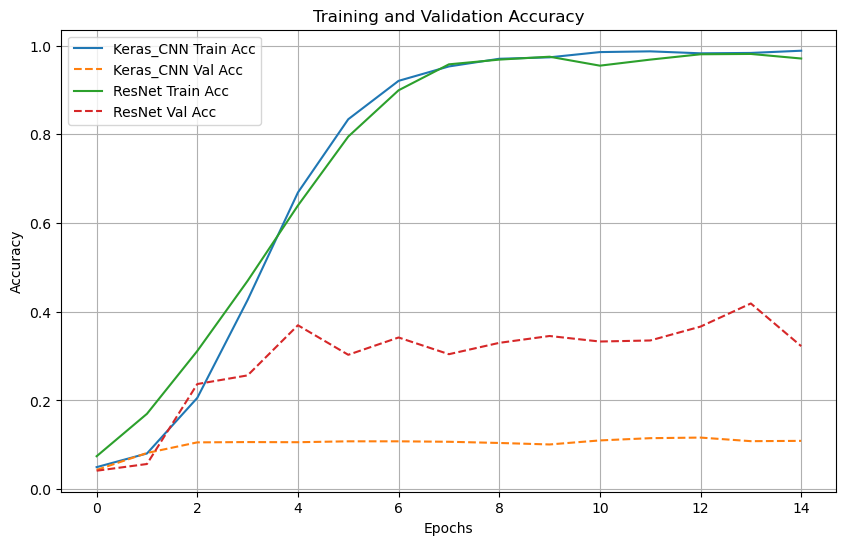

In [15]:
plt.figure(figsize=(10, 6))

for name, history in history_dict.items():
    plt.plot(history['accuracy'], label=f'{name} Train Acc')
    plt.plot(history['val_accuracy'], linestyle='dashed', label=f'{name} Val Acc')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid()
plt.show()


## Conclusions

It is reasonable to believe that, with more epochs, ResNet could outperform the Keras CNN model. We observe, however, that both of them lowers their performance once reached almost perfect scores.

As previously mentioned, EfficientNet was almost implemented in this project, but time constraints prevented it. Due to frequent kernel resets—each taking several hours—training was limited to 10 to 20 epochs for the existing models, rather than the 40 epochs EfficientNet required. This limitation was further impacted by the fact that the dataset had already been divided.

-----------------


## Model application

### **Function: predict_airplane**
This function loads a model, processes an input image, and predicts its class.

#### **Steps:**
1. **Load the Model**  
   - The function receives a model function (model_func) and a model name (model_name).
   - A model is instantiated using the provided function.
   - The pre-trained weights are loaded from a .h5 file.

2. **Process the Input Image**  
   - The image is loaded and resized to match the model’s input size (IMG_SIZE).
   - The pixel values are normalized to a [0,1] range.
   - The image is expanded to match the expected batch format.

3. **Make Predictions**  
   - The processed image is passed through the model.
   - The model returns probability scores for each class.
   - The highest probability determines the predicted class.
   - The confidence score is extracted from the highest probability.

4. **Output Results**  
   - The predicted class and confidence score are printed.
   - The function returns the prediction and confidence.

### **Function: on_drop**
This function is triggered when an image is dropped into the graphical interface.

#### **Steps:**
1. Extracts the file path from the dropped image.
2. Iterates through a dictionary of models (models).
3. Calls predict_airplane for each model.
4. Prints the model name, prediction, and confidence score.
5. Closes the application (root.quit()).


In [37]:
def predict_airplane(model_func, model_name, image_path, classes):
    model = model_func(IMG_SIZE + (3,), len(classes))
    model.load_weights(f'./{model_name}.weights.h5')  
    
    img = image.load_img(image_path, target_size=IMG_SIZE)
    img_array = image.img_to_array(img) / 255.0  
    img_array = np.expand_dims(img_array, axis=0)  
    
    predictions = model.predict(img_array)
    pred_label = classes[np.argmax(predictions)]  
    confidence = np.max(predictions)  
    
    print(f"Predicted Class: {pred_label}")
    print(f"Confidence: {confidence * 100:.2f}%")
    
    return pred_label, confidence

print('Function done')

Function done


In [38]:
def on_drop(event, root, models, classes):
    file_path = event.data
    
    print(f"Image path: {file_path}")
    
    for model_name, (model_func, crop_path) in models.items():
        print(f"Using model: {model_name}")
        label, confidence = predict_airplane(model_func, model_name, file_path, classes)
        print(f"Prediction: {label} with confidence: {confidence * 100:.2f}%")
        
    root.quit()  

root = TkinterDnD.Tk()
root.title("Airplane Class Prediction")
root.geometry("400x200")

label = tk.Label(root, text="Drag and drop an image here", width=40, height=10, relief="solid")
label.pack(padx=10, pady=10)

label.drop_target_register(DND_FILES)
label.dnd_bind('<<Drop>>', lambda event, root=root: on_drop(event, root, models, classes))

root.mainloop()

Exception in Tkinter callback
Traceback (most recent call last):
  File "C:\Users\Usuario\anaconda3\Lib\tkinter\__init__.py", line 1948, in __call__
    return self.func(*args)
           ^^^^^^^^^^^^^^^^
  File "C:\Users\Usuario\AppData\Local\Temp\ipykernel_18152\3358094611.py", line 21, in <lambda>
    label.dnd_bind('<<Drop>>', lambda event, root=root: on_drop(event, root, models, classes))
                                                                             ^^^^^^
NameError: name 'models' is not defined
